In [1]:
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import umap
import networkx as nx
from sklearn.cluster import HDBSCAN
import joblib

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = '/sciclone/geograd/stmorse/reddit/mbkm_50'

In [3]:
# LOAD CENTROIDS

start_year = 2007
end_year = 2015
start_month = 1
end_month = 12

years = [str(y) for y in range(start_year, end_year+1)]
months = [f'{m:02}' for m in range(start_month, end_month+1)]
yrmo = [(yr, mo) for yr in years for mo in months]

C = []
Ck = 50  # TODO: doesn't need to be the same every month
for year, month in yrmo:
    with open(os.path.join(base_path, f'models/model_cc_{year}-{month}.npz'), 'rb') as f:
        cc = np.load(f)['cc']
        if Ck != cc.shape[0]: print(Ck, cc.shape[0])
        C.append(cc)
C = np.vstack(C)
print(C.shape)

T = []
for year, month in yrmo:
    with open(os.path.join(base_path, f'tfidf/tfidf_{year}-{month}.pkl'), 'rb') as f:
        tfidf = pickle.load(f)
    # TODO: hacky, maybe 'tfidf' shouldn't be a dict
    for j in range(len(tfidf['tfidf'].keys())):
        T.append(tfidf['tfidf'][j]['keywords'])
print(len(T))

(5400, 384)
5400


In [9]:
print(f'Num time periods: {C.shape[0] // Ck}')

Num time periods: 108


In [4]:
# DIM REDUCTION

u_embedder = umap.UMAP(
    n_neighbors=15,
    n_components=10,
    metric='euclidean',
    init='spectral',
    min_dist=0.1,
    spread=1.0
)

Cu = u_embedder.fit_transform(C)
Cu.shape

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(5400, 10)

In [13]:
Cu2d = umap.UMAP(n_components=2).fit_transform(C)
Cu2d.shape

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(5400, 2)

In [10]:
hdbs = HDBSCAN(
    min_cluster_size=5,
    min_samples=None,       # None defaults to min_cluster_size
    cluster_selection_epsilon=0.0,
    max_cluster_size=300,
    metric='euclidean',
    store_centers='both',   # centroid and medoid
)
hdbs.fit(Cu)

labels, cnts = np.unique(hdbs.labels_, return_counts=True)

In [11]:
cnts

array([1414,   20,   20,  122,   25,    7,   20,   53,    8,   24,   12,
          6,    8,   17,   10,   24,    7,    6,   13,    6,   38,    8,
         12,   10,   13,   46,    6,   65,  150,   17,   59,   14,    9,
         20,    6,   84,   57,   23,   50,   22,   20,   10,    8,   28,
          9,   20,   12,    9,   12,    6,  119,   13,  180,   10,   42,
         21,    5,   24,    8,   13,    9,   11,   48,   11,   14,    6,
         12,    6,    6,    6,   12,   27,    7,    9,    5,   28,   25,
          5,    5,   19,   40,    6,   26,   37,   40,   12,   29,    9,
         20,    9,   27,   13,   12,    9,    5,   16,    6,    6,    7,
          9,    6,    5,   10,   25,    8,   31,    7,   13,   15,   22,
          5,   30,   14,   13,   24,  129,   13,    6,   11,    6,    7,
          5,    8,   11,    7,   45,    6,   23,    6,   16,   52,   56,
         24,    7,   24,    9,    7,   33,    6,   17,   25,    8,   25,
          7,    8,   40,   36,   24,   10,    6,   

/local/scr/stmorse/TMPDIR/ipykernel_1831333/700964494.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)


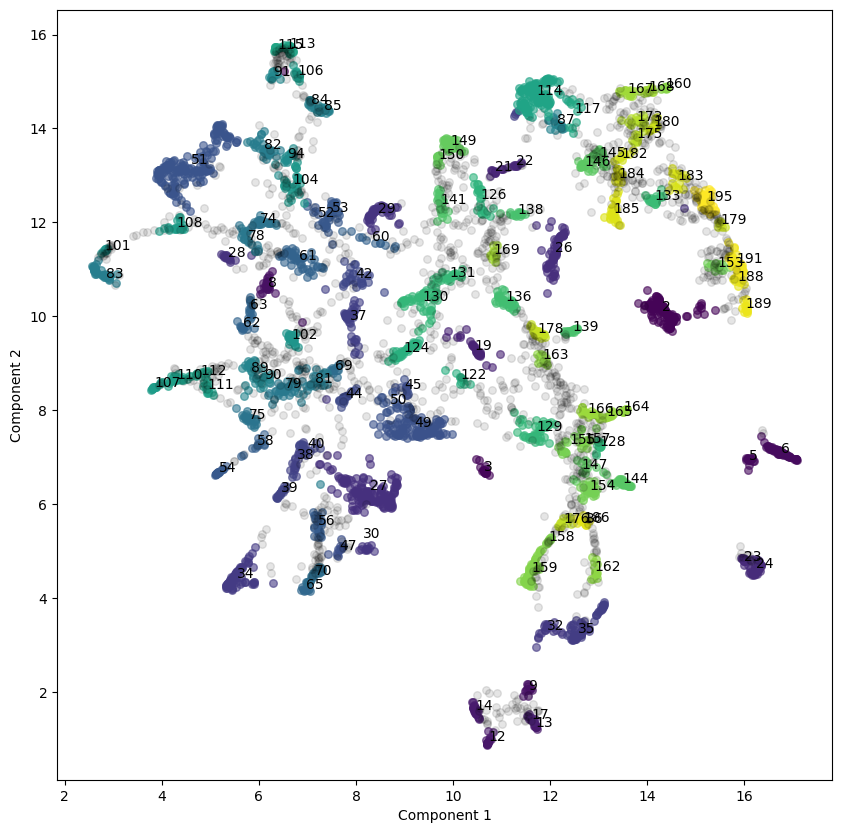

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

n_clusters = np.amax(hdbs.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for k in range(2, n_clusters):
    # NOTE: ignore coi=1 for viz (outlier)
    if k == 1: continue

    idx = np.where(hdbs.labels_ == k)[0]

    if len(idx) < 10:
        continue
    
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)

    centroid = np.average(Cu2d[idx,:], axis=0)
    ax.text(centroid[0], centroid[1], k)

# plot uncategorized
idx = np.where(hdbs.labels_ == -1)[0]
ax.scatter(Cu2d[idx, 0], Cu2d[idx, 1], s=30, c='k', alpha=0.1)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

plt.show()

In [17]:
coi = 191

idx = np.where(hdbs.labels_ == coi)[0]
for x in idx:
    print(f'{x} ({x // 50}) ({hdbs.probabilities_[x]:.3f}): {T[x][:5]}')

71 (1) (0.614): ['coins' 'dollar' 'cash' 'pennies' 'paycheck']
115 (2) (0.651): ['price' 'median' 'market' 'estate' 'income']
213 (4) (0.674): ['rich' 'gold' 'dollars' 'cash' 'dollar']
713 (14) (0.591): ['gold' 'dollar' '000' 'pennies' 'ounce']
931 (18) (0.674): ['service' 'food' 'pizza' 'tip' 'store']
1095 (21) (0.727): ['buying' 'prices' 'market' 'cash' 'sell']
1104 (22) (0.629): ['prices' 'price' 'buying' 'cheap' 'market']
1494 (29) (0.713): ['price' 'game' 'games' 'pay' 'cost']
1568 (31) (0.674): ['profit' 'greed' 'marketing' 'revenue' 'selling']
1600 (32) (0.651): ['food' 'prices' 'expensive' 'price' 'cheaper']
1607 (32) (0.775): ['cash' 'pay' 'dollars' 'sell' 'selling']
1792 (35) (0.944): ['bucks' 'cents' 'tooth' 'dollar' 'frugal']
1939 (38) (0.684): ['prices' 'price' 'store' 'buy' 'sell']
1963 (39) (0.576): ['prices' 'cost' 'price' 'cheaper' 'car']
2296 (45) (0.651): ['price' 'prices' 'profit' 'market' 'cash']
2388 (47) (0.674): ['cash' 'dollars' '3232' 'donating' 'donated']
253